Перед вами данные взаимодействий с рекламными объявлениями на VK площадке за 6 дней. 
И таблица с характеристиками рекламных клиентов (те, кто разместил эти объявления).

#### ads_data.csv – данные взаимодействий с рекламными объявлениями
- date – дата
- time – время
- event – действие (просмотр/клик)
- platform – платформа
- ad_id – id объявления
- client_union_id – id рекламного кабинета
- campaign_union_id – id рекламной кампании
- ad_cost_type – тип оплаты
- ad_cost – цена
- has_video – есть ли видео
- target_audience_count – размер аудитории

#### ads_clients_data.csv – характеристики рекламных клиентов
- date – дата
- client_union_id – id рекламного кабинета
- community_id – id сообщества
- create_date – дата создания рекламного клиента


### Задачи:


- Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период;
- Нарисуйте график распределения показов на объявление за весь период;
- Посчитать скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года?
- Поиск аномалий в данных;
- Найти среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом;
- Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

%matplotlib inline

In [29]:
sns.set (
        font_scale = 2,
        style      = 'whitegrid',
        rc         = {'figure.figsize':(20,7)},
        palette    = 'plasma')

In [4]:
ads_clients_data = pd.read_csv('ads_clients_data.csv', parse_dates=['create_date'])

In [5]:
ads_data = pd.read_csv('ads_data.csv', parse_dates=['date', 'time'])

In [6]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [7]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


#### Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период.

In [8]:
event_number = ads_data.groupby(['ad_id', 'event'], as_index=False) \
                       .agg({'time':'count'}) \
                       .rename(columns={'time':'event_number'})

In [9]:
pivot_event_number = event_number.pivot(index='ad_id', 
                                        columns='event', 
                                        values='event_number') \
                                        .fillna(0)

In [10]:
mean_clicks_views = pivot_event_number.mean() \
                                      .round()

mean_clicks_views

event
click    113.0
view     923.0
dtype: float64

#### Нарисуйте график распределения показов на объявление за весь период.

In [11]:
views_count = event_number.query('event == "view"')
views_count.head()

,ad_id,event,event_number
1,2,view,101
3,3,view,184
5,1902,view,41
6,2064,view,35
8,2132,view,58


C:\Users\Юлия\AppData\Local\Temp\ipykernel_14200\971472696.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(views_count['event_number'], kde=True);


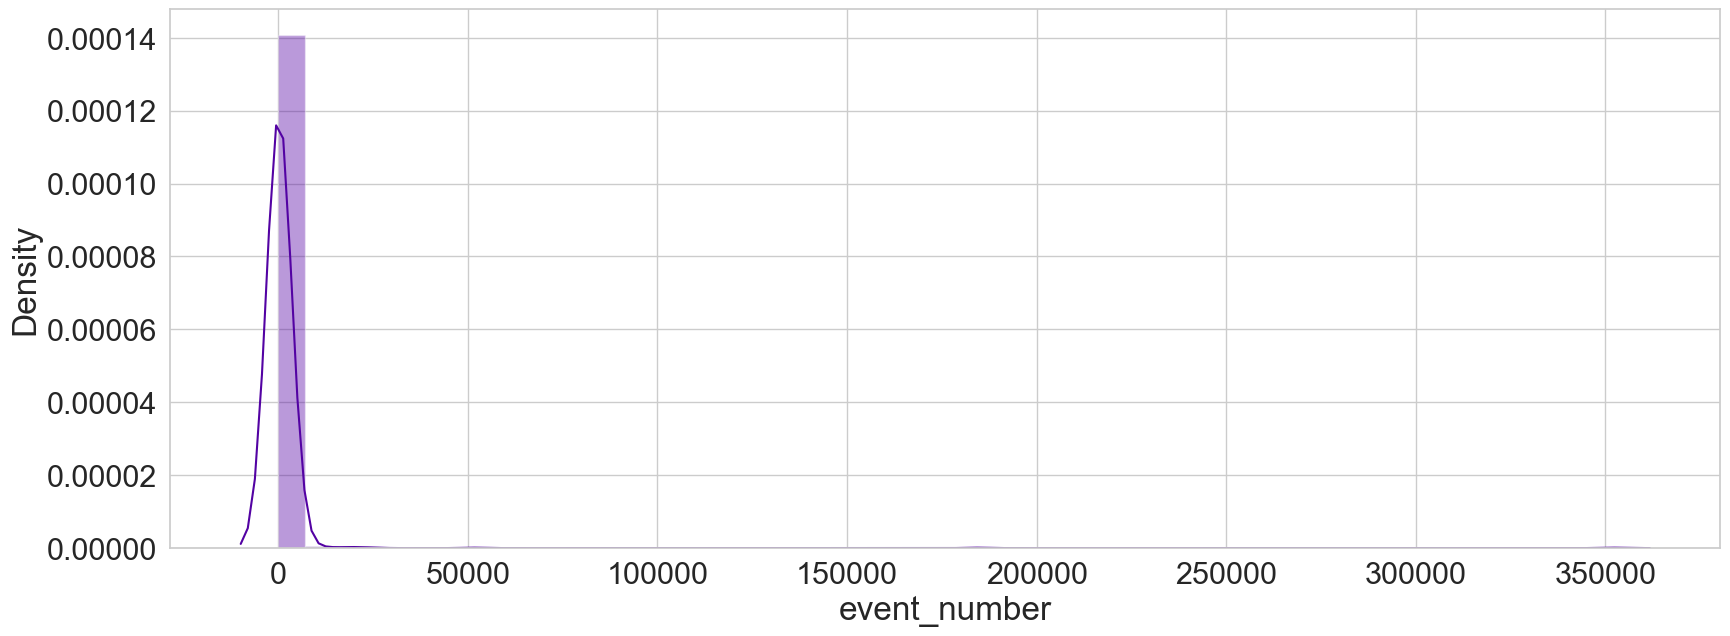

In [32]:
sns.distplot(views_count['event_number'], kde=True);

In [13]:
views_count.event_number.idxmax()
# id с самой масштабной рекламой по показам

1221

In [14]:
views_count.describe()

,ad_id,event_number
count,956.000000,956.000000
mean,57756.006276,931.822176
std,38701.096189,13006.492754
min,2.000000,10.000000
25%,29747.750000,36.000000
50%,43146.500000,84.000000
75%,107173.000000,209.250000
max,122078.000000,351802.000000


In [15]:
# сделаем логарифмирование данных 
views_count = views_count.assign(log_views = np.log(views_count['event_number']))

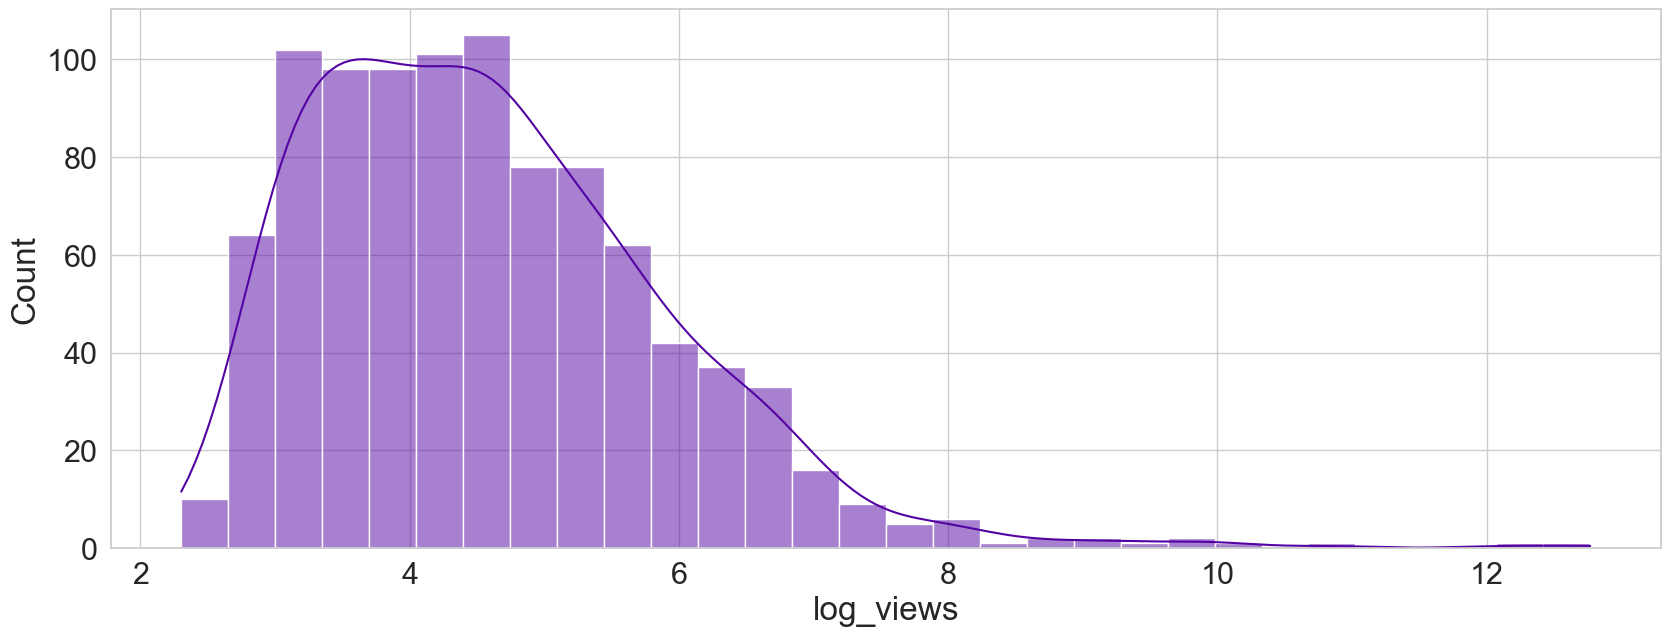

In [30]:
sns.histplot(views_count['log_views'], kde=True);

#### Посчитать скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года?

In [17]:
ads_view = ads_data.query('event == "view"') \
                   .pivot_table(index    = 'ad_id',
                                 columns = 'date',
                                 values  = 'time',
                                 aggfunc = 'count')

In [84]:
ads_view

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
2,83.0,18.0,NaN,NaN,NaN,NaN
3,158.0,26.0,NaN,NaN,NaN,NaN
1902,NaN,NaN,34.0,7.0,NaN,NaN
2064,NaN,28.0,7.0,NaN,NaN,NaN
2132,NaN,NaN,25.0,27.0,6.0,NaN
...,...,...,...,...,...,...
122004,85.0,15.0,NaN,NaN,NaN,NaN
122013,NaN,NaN,NaN,134.0,22.0,NaN
122023,NaN,NaN,NaN,53.0,15.0,NaN


In [18]:
ads_mean = ads_view.mean()
# Посчитаем обычное среднее для каждой даты

In [19]:
ads_mean_rolling_2 = ads_view.mean().rolling(2).mean().round(0)
# Посчитаем скользящее среднее c окном 2 для каждой даты

In [20]:
ads_mean_rolling_2

date
2019-04-01      NaN
2019-04-02    146.0
2019-04-03    151.0
2019-04-04    420.0
2019-04-05    798.0
2019-04-06    598.0
dtype: float64

#### Проверить: есть ли аномалии в данных? Если есть, найти их

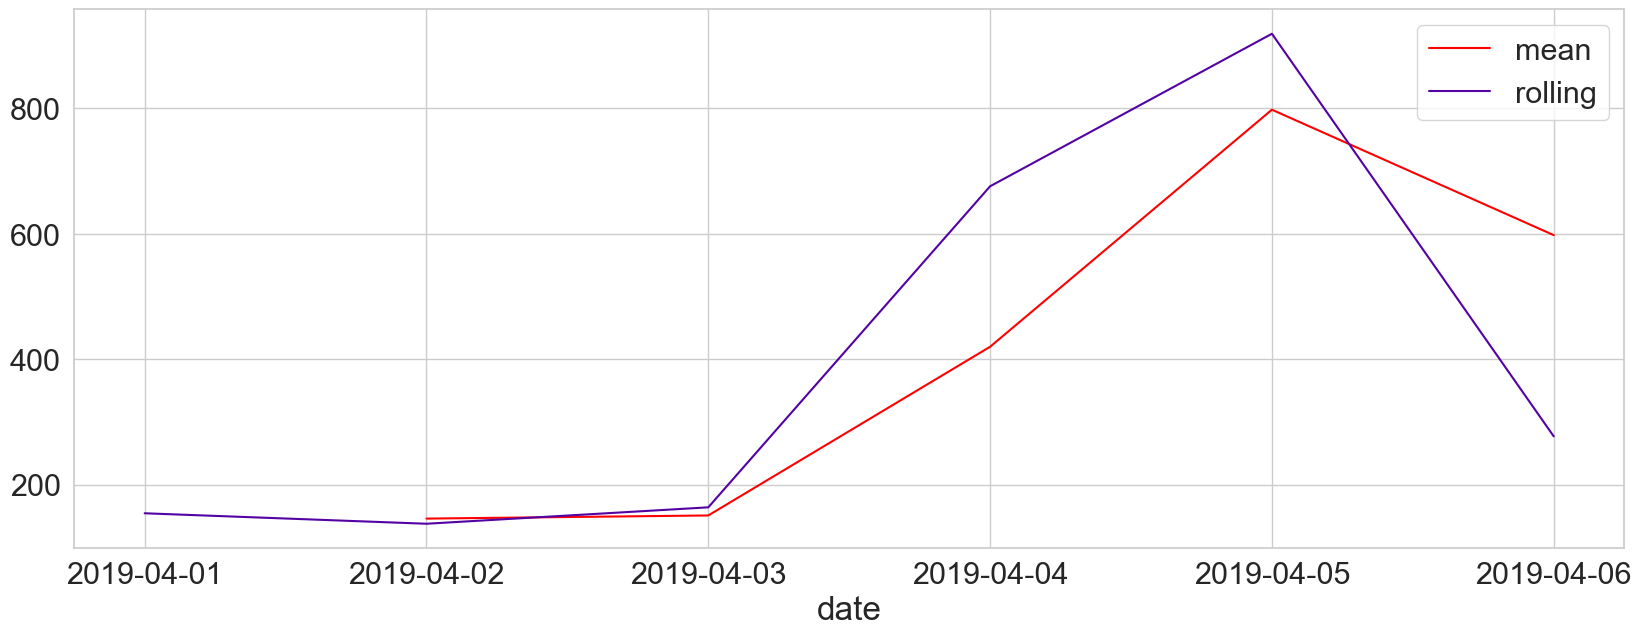

In [37]:
sns.lineplot(ads_mean_rolling_2, label='mean', color='red')
sns.lineplot(ads_mean, label='rolling');

In [47]:
(ads_mean - ads_mean_rolling_2).abs()
# абсолютная разница по модулю между скользящим средним и обычным средним

date
2019-04-01           NaN
2019-04-02      8.213018
2019-04-03     12.952778
2019-04-04    255.901720
2019-04-05    121.109677
2019-04-06    320.877273
dtype: float64

In [54]:
anomaly_day = (ads_mean - ads_mean_rolling_2).abs().idxmax()
# самая большая по модулю аномалия (наиболее проблемный день)

In [74]:
difference_value = ads_mean.subtract(ads_mean_rolling_2)[anomaly_day].round(4)
# Проверяем знак аномалии 

In [75]:
difference_value

-320.8773

In [81]:
# Ищем максимальное число показов за этот день, если значение отрицательное
if difference_value < 0:
    anomaly_id = ads_view[anomaly_day].idxmax()
#  Ищем минимальное число показов за этот день, если значение положительное
else:
    anomaly_id = ads_view[anomaly_day].idxmin()


In [82]:
anomaly_id

112583

In [83]:
ads_view.loc[anomaly_id]

date
2019-04-01         NaN
2019-04-02         NaN
2019-04-03         NaN
2019-04-04         NaN
2019-04-05    302811.0
2019-04-06     48991.0
Name: 112583, dtype: float64

In [93]:
def anomaly_id(pivot_table_ads_view):
    
    
    
    # Для каждой даты найти свое среднее
    ads_mean = pivot_table_ads_view.mean()
    # Найти среднее скользящее с окном 2
    ads_mean_rolling_2 = ads_view.mean().rolling(2).mean().round(0)
    # Найти разность между средним и скользящим средним
    mean_difference = ads_mean.subtract(ads_mean_rolling_2)
    anomaly_day = mean_difference.abs().idxmax()
    
    
    # Найти знак значения (отрицательное или положительная разность)
    difference_value = mean_difference[anomaly_day].round(4) 
    
    # Найти максимальное число показов за этот день, если значение отрицательное
    if difference_value < 0:
        anomaly_id = pivot_table_ads_view[anomaly_day].idxmax()
    # Найти минимальное число показов за этот день, если значение положительное
    else:
        anomaly_id = pivot_table_ads_view[anomaly_day].idxmin()

    
    # Найти id
    return anomaly_id

In [92]:
anomaly_id(ads_view)

112583

#### Найти среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

In [96]:
full_data = ads_data.merge(ads_clients_data.drop(columns=['date', 'community_id']))
full_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04


In [107]:
average_create_to_apply = full_data.groupby('client_union_id', as_index=False) \
                                    .apply(lambda group: (group.date - group.create_date).min()) \
                                    .mean() 

In [108]:
average_create_to_apply

client_union_id                   47921.434368
None               124 days 09:04:43.532219570
dtype: object

Ответ: 124 дня

#### Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней

In [105]:
threshhol = pd.to_timedelta(365, unit='d')

In [118]:
average_create = full_data.groupby('client_union_id') \
                          .apply(lambda group: (group.date - group.create_date).min()) 

In [123]:
average_create = average_create.loc[average_create < threshhol]

In [132]:
count_account = ads_clients_data.client_union_id.nunique()


In [135]:
round(average_create.shape[0] / count_account * 100, 2)

0.69

Вывод: конверсия меньше 1%

#### Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).

In [137]:
bins = [pd.to_timedelta('0d'),
        pd.to_timedelta('30d'),
        pd.to_timedelta('90d'),
        pd.to_timedelta('180d'),
        pd.to_timedelta('365d')]


In [138]:
labels = ['less than 30 days',
         '30-90 days',
         '90-180 days',
         '180-365 days']

In [141]:
category_create = pd.cut(average_create, bins=bins, labels=labels)

In [143]:
category_create.value_counts()

90-180 days          396
30-90 days           263
180-365 days         168
less than 30 days     11
dtype: int64

Ответ: 263

In [153]:
fig = px.bar(category_create.value_counts(), color_discrete_sequence=["purple"])
fig